In [1]:
%pylab inline

import numpy as np
import pylab
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [6]:
import nengo

# Parameters of the leaky competing accumulator model
dimensions = 3
k = 1
beta = 1
dt = 0.001
tau_model = 0.01
baseline = -1

# Settings for the nengo network
n_neurons = 2000
neuron_type = nengo.neurons.LIF()
tau_actual = 0.1
tau_probe = 0.01
a = np.exp(-dt / tau_actual)

# eqn (4) ignoring truncation, put into the canonical form:
#   x[t+dt] = Ax[t] + Bu
inhibit = np.ones((dimensions, dimensions))
inhibit[np.diag_indices(dimensions)] = 0
I = np.eye(dimensions)
B = dt / tau_model
A = (-k * I - beta * inhibit) * dt / tau_model + I

with nengo.Network() as model:
    # Usher and McClelland paper
    stim = [
        nengo.Node(output=nengo.processes.PresentInput([0, 0.15, 0.30], 0.5)),
        nengo.Node(output=nengo.processes.PresentInput([0.4, 0.1], 0.5)),
        nengo.Node(output=nengo.processes.PresentInput([0.25], 0.5))]
    x = nengo.Ensemble(
        n_neurons, dimensions)#,
        #intercepts=nengo.dists.Uniform(baseline, 1),
        #encoders=nengo.dists.Choice(I))

    xt = nengo.Node(size_in=dimensions)
    nengo.Connection(x, xt, synapse=None)#, function=lambda x: x.clip(baseline), synapse=None)
    
    for i in range(dimensions):
        nengo.Connection(
            stim[i], x[i],
            transform=B / (1 - a),  # discrete principle 3
            synapse=tau_actual)

    nengo.Connection(
        xt, x,
        transform=(A - a * I) / (1 - a),  # discrete principle 3
        synapse=tau_actual)
    
    p_stim = [nengo.Probe(stim[i], synapse=tau_probe) for i in range(dimensions)]
    p_xt = nengo.Probe(xt, synapse=tau_probe)
    
    # Nengo BG
    n_bg_ensembles = 15
    bg = nengo.networks.BasalGanglia(
        dimensions=dimensions, n_neurons_per_ensemble=n_neurons / n_bg_ensembles,
        input_bias=0.5)
    assert (sum(ens.n_neurons for ens in bg.all_ensembles) / n_bg_ensembles ==
            n_neurons / n_bg_ensembles)

    for i in range(dimensions):
        nengo.Connection(
            stim[i], bg.input[i], synapse=tau_actual)
    
    p_bg = nengo.Probe(bg.output, synapse=tau_probe)    
    
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(3.0)

Building finished in 0:00:05.                                                   
Simulating finished in 0:00:18.                                                 


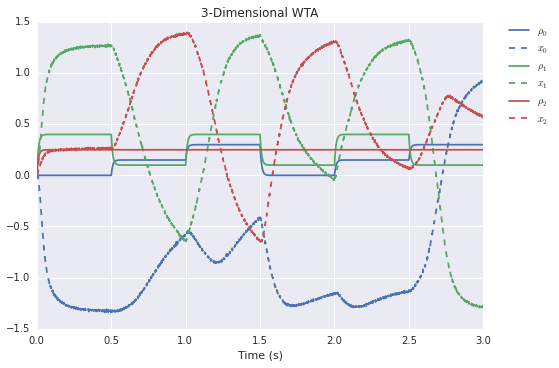

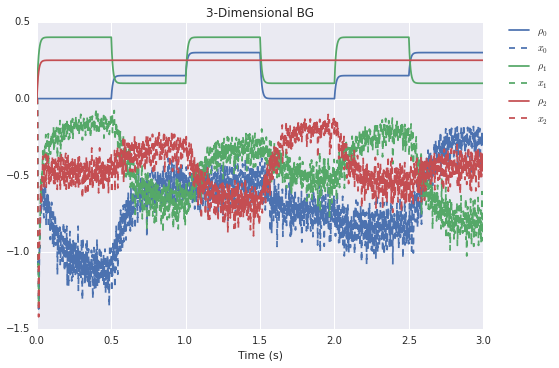

In [7]:
pal = sns.color_palette(None, dimensions)

pylab.figure()
pylab.title("%d-Dimensional WTA" % dimensions)
for i in range(dimensions):
    pylab.plot(sim.trange(), sim.data[p_stim[i]],
               label=r"$\rho_%d$" % i, c=pal[i])
    pylab.plot(sim.trange(), sim.data[p_xt][:, i],
               label="$x_%d$" % i, c=pal[i], linestyle='--')
pylab.xlabel('Time (s)')
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.show()

pylab.figure()
pylab.title("%d-Dimensional BG" % dimensions)
for i in range(dimensions):
    pylab.plot(sim.trange(), sim.data[p_stim[i]],
               label=r"$\rho_%d$" % i, c=pal[i])
    pylab.plot(sim.trange(), sim.data[p_bg][:, i],
               label="$x_%d$" % i, c=pal[i], linestyle='--')
pylab.xlabel('Time (s)')
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.show()
